In [ ]:
!pip install torch_geometric

In [40]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.data import Data, DataLoader
# from torch_geometric.nn import GCNConv
import numpy as np
import jax.numpy as jnp
import jraph
from jraph import GraphConvolution, GraphMapFeatures
from flax import nnx
import logging
from tqdm.notebook import tqdm # progress bar
import optax
logging.basicConfig(level=logging.INFO)
import matplotlib. pyplot as plt

In [2]:
# Define the domain and discretization
nx, ny = 20, 20  # Grid size
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xx, yy = np.meshgrid(x, y)
print(yy.ravel().shape)
nodes_pos = jnp.array(np.vstack([xx.ravel(), yy.ravel()]).T)  # Graph nodes' coordinates
num_nodes = jnp.array([nx*ny])

(400,)


In [3]:
# Define edges: connect each node to its neighbors
edges = []
for i in range(nx):
    for j in range(ny):
        if i < nx - 1:  # Horizontal edges
            edges.append([i * ny + j, (i + 1) * ny + j])
            edges.append([(i + 1) * ny + j, i * ny + j])
        if j < ny - 1:  # Vertical edges
            edges.append([i * ny + j, i * ny + (j + 1)])
            edges.append([i * ny + (j + 1), i * ny + j])
print(edges)
# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index = jnp.array(edges).T
senders = edge_index[0]
num_edges = jnp.array(len(senders))
receivers = edge_index[1]
print(edge_index, num_edges)

[[0, 20], [20, 0], [0, 1], [1, 0], [1, 21], [21, 1], [1, 2], [2, 1], [2, 22], [22, 2], [2, 3], [3, 2], [3, 23], [23, 3], [3, 4], [4, 3], [4, 24], [24, 4], [4, 5], [5, 4], [5, 25], [25, 5], [5, 6], [6, 5], [6, 26], [26, 6], [6, 7], [7, 6], [7, 27], [27, 7], [7, 8], [8, 7], [8, 28], [28, 8], [8, 9], [9, 8], [9, 29], [29, 9], [9, 10], [10, 9], [10, 30], [30, 10], [10, 11], [11, 10], [11, 31], [31, 11], [11, 12], [12, 11], [12, 32], [32, 12], [12, 13], [13, 12], [13, 33], [33, 13], [13, 14], [14, 13], [14, 34], [34, 14], [14, 15], [15, 14], [15, 35], [35, 15], [15, 16], [16, 15], [16, 36], [36, 16], [16, 17], [17, 16], [17, 37], [37, 17], [17, 18], [18, 17], [18, 38], [38, 18], [18, 19], [19, 18], [19, 39], [39, 19], [20, 40], [40, 20], [20, 21], [21, 20], [21, 41], [41, 21], [21, 22], [22, 21], [22, 42], [42, 22], [22, 23], [23, 22], [23, 43], [43, 23], [23, 24], [24, 23], [24, 44], [44, 24], [24, 25], [25, 24], [25, 45], [45, 25], [25, 26], [26, 25], [26, 46], [46, 26], [26, 27], [27, 26

In [53]:
# Define node features: (x, y, initial guess for u)
node_features = jnp.array(jnp.c_[nodes_pos, np.zeros((nx * ny, 1))])

In [54]:
# Create jraph graph
graph = jraph.GraphsTuple(
    nodes=node_features,
    edges=None,
    senders=senders,
    receivers=receivers,
    n_node=num_nodes,
    n_edge=num_edges,
    globals=None
    )

In [75]:
# Define the source term f(x, y) for the Poisson equation
def source_term(x, y):
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

source_values = jnp.array(source_term(nodes_pos[:, 0], nodes_pos[:, 1])).reshape(-1,1)
print(source_values.shape)

(400, 1)


Define the GCN architecture:

In [76]:
class GCN(nnx.Module):
  def __init__(self, in_features, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(in_features, 16, rngs=rngs)
    self.linear2 = nnx.Linear(16, 32, rngs=rngs)
    self.linear3 = nnx.Linear(32, 1, rngs=rngs)

  def __call__(self, graph):
    self._gn1 = GraphConvolution(update_node_fn=self.linear1)
    self._gn2 = GraphConvolution(update_node_fn=self.linear2)
    self._gn3 = GraphConvolution(update_node_fn=self.linear3)
    self._act = GraphMapFeatures(embed_node_fn=nnx.relu)
    y = self._gn1(graph)
    y = self._act(y)
    y = self._gn2(y)
    y = self._act(y)
    y = self._gn3(y)
    return y.nodes

In [77]:
model = GCN(3, nnx.Rngs(42))
model(graph)

Array([[-0.00089669],
       [ 0.00362597],
       [ 0.01137426],
       [ 0.0213886 ],
       [ 0.03088619],
       [ 0.04037311],
       [ 0.04983666],
       [ 0.05946446],
       [ 0.06896724],
       [ 0.07850097],
       [ 0.08824807],
       [ 0.09807601],
       [ 0.10800057],
       [ 0.1179389 ],
       [ 0.12787725],
       [ 0.13781558],
       [ 0.14945929],
       [ 0.158808  ],
       [ 0.17599872],
       [ 0.14066777],
       [-0.00515392],
       [-0.00199846],
       [ 0.00628605],
       [ 0.01624296],
       [ 0.02796955],
       [ 0.0395575 ],
       [ 0.0511561 ],
       [ 0.06191746],
       [ 0.07253241],
       [ 0.08314388],
       [ 0.09378216],
       [ 0.10469042],
       [ 0.11563697],
       [ 0.12665355],
       [ 0.13769238],
       [ 0.14851135],
       [ 0.15968159],
       [ 0.17508034],
       [ 0.18480143],
       [ 0.17336807],
       [-0.0122317 ],
       [-0.01136089],
       [-0.00588452],
       [ 0.00254566],
       [ 0.01233309],
       [ 0

Training functions:

In [78]:
@nnx.jit
def loss_fn(model, graph, labels):
    output_graph_nodes = model(graph)
    loss = optax.losses.l2_loss(output_graph_nodes, labels)
    return jnp.mean(loss)

# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, graph, labels):
    loss, grads = nnx.value_and_grad(loss_fn)(model, graph, labels)
    optimizer.update(grads)
    return loss

def train(model, optimizer, graph, labels, epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        train_loss = train_step(model, optimizer, graph, labels)

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

Let's train the GCN!

In [79]:
# Define the optimizer
lr = 1e-2 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

epochs = 100
labels = source_values

train_loss_history = train(model, optimizer, graph, labels, epochs, log_period_epoch=10, show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

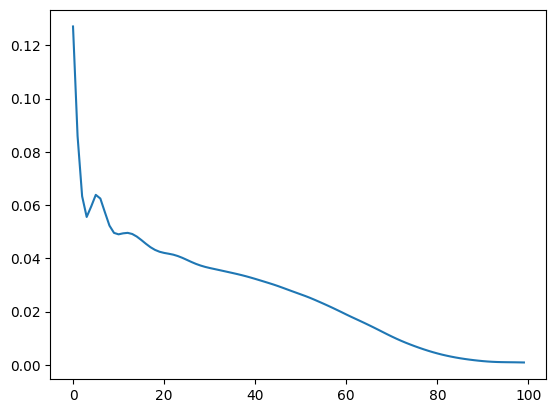

In [80]:
plt.plot(train_loss_history)

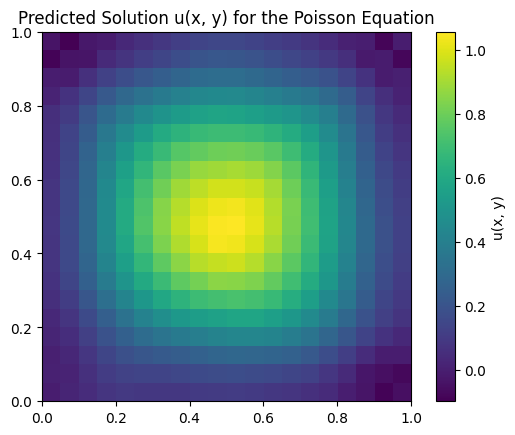

In [81]:
# Visualize the solution using matplotlib
import matplotlib.pyplot as plt
predicted_u = model(graph).reshape(nx, ny)
plt.imshow(predicted_u, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.title('Predicted Solution u(x, y) for the Poisson Equation')
plt.show()

/tmp/ipykernel_84666/855434899.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph.y = torch.tensor(y, dtype=torch.float).view(-1, 1)


Epoch 10/100, Loss: 0.0061
Epoch 20/100, Loss: 0.0036
Epoch 30/100, Loss: 0.0034
Epoch 40/100, Loss: 0.0004
Epoch 50/100, Loss: 0.0005
Epoch 60/100, Loss: 0.0005
Epoch 70/100, Loss: 0.0015
Epoch 80/100, Loss: 0.0023
Epoch 90/100, Loss: 0.0024
Epoch 100/100, Loss: 0.0004


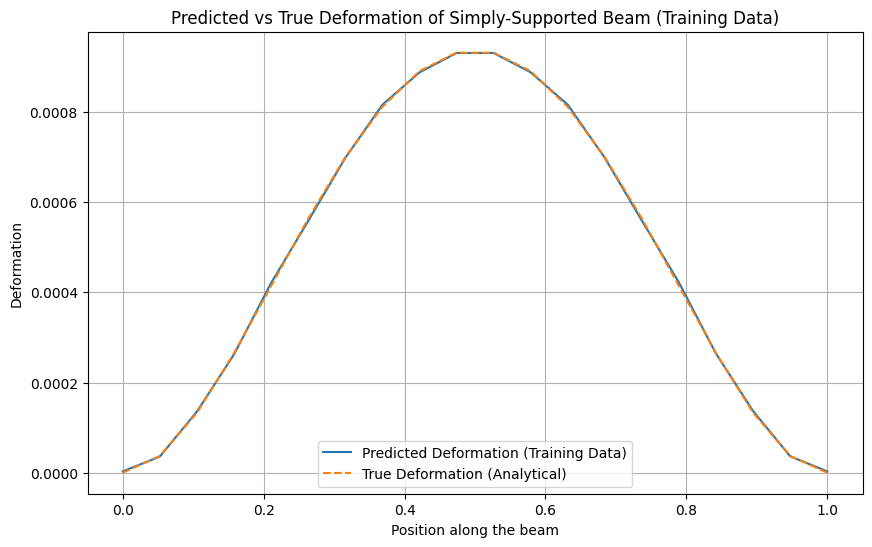

In [279]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Analytical solution for a simply-supported beam under uniform load
def beam_deflection(x, L, w, E, I):
    return (w * L**4 / (24 * E * I)) * ((x / L)**4 - 2 * (x / L)**3 + (x / L)**2)

# Define the Graph Neural Network (unchanged)
class RodDeformationGNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(RodDeformationGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = self.conv3(x, edge_index)
        # x = F.relu(x)
        x = self.conv4(x, edge_index)
        return x

# Create a simple rod graph
def create_rod_graph(num_nodes, load, load_mean, load_std, position_mean, position_std):
    edge_index = torch.tensor([[i, i+1] for i in range(num_nodes-1)] +
                              [[i+1, i] for i in range(num_nodes-1)], dtype=torch.long).t().contiguous()
    
    x = torch.linspace(0, 1, num_nodes).view(-1, 1)
    load_normalized = (load - load_mean) / load_std  # Normalize the load
    load_features = torch.full((num_nodes, 1), load_normalized)
    
    # Normalize position using the computed mean and standard deviation
    x_normalized = (x - position_mean) / position_std
    
    # Concatenate normalized position and normalized load
    x = torch.cat([x_normalized, load_features], dim=1)
    return Data(x=x, edge_index=edge_index)

# Generate synthetic data using the analytical solution
def generate_data(num_samples, num_nodes, L, E, I):
    data_list = []
    all_positions = []
    all_loads = []
    all_deformations = []

    for _ in range(num_samples):
        load = torch.rand(1).item() * 1e5  # Random load between 0 and 10
        x_positions = torch.linspace(0, L, num_nodes)
        y = beam_deflection(x_positions, L, load, E, I)
        
        all_positions.append(x_positions)
        all_loads.append(load)
        all_deformations.append(y)
    
    # Convert lists to tensors for easier manipulation
    all_positions = torch.cat(all_positions).view(-1, 1)
    all_loads = torch.tensor(all_loads)
    all_deformations = torch.cat(all_deformations).view(-1, 1)

    # Calculate the mean and standard deviation for normalization
    position_mean = all_positions.mean()
    position_std = all_positions.std()
    load_mean = all_loads.mean()
    load_std = all_loads.std()
    deformation_mean = all_deformations.mean()
    deformation_std = all_deformations.std()

    # Now create the graphs with normalized values
    for i in range(num_samples):
        load = all_loads[i]
        graph = create_rod_graph(num_nodes, load, load_mean, load_std, position_mean, position_std)
        
        # Normalize the deformation
        y = (beam_deflection(torch.linspace(0, L, num_nodes), L, load, E, I) - deformation_mean) / deformation_std
        graph.y = torch.tensor(y, dtype=torch.float).view(-1, 1)
        data_list.append(graph)

    return data_list, position_mean, position_std, load_mean, load_std, deformation_mean, deformation_std

# Training function (unchanged)
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Main execution
num_nodes = 20
num_samples = 1000
hidden_channels = 64
L = 1.0  # Length of the beam
E = 200e9  # Modulus of Elasticity (Pa) for steel
I = 1e-6  # Moment of inertia (m^4)

# Generate data and normalize using z-score normalization
data_list, position_mean, position_std, load_mean, load_std, deformation_mean, deformation_std = generate_data(num_samples, num_nodes, L, E, I)

# Create model
model = RodDeformationGNN(num_node_features=2, hidden_channels=hidden_channels)  # 2 input features: position + load
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop (unchanged)
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for data in data_list:
        loss = train(model, data, optimizer, criterion)
        total_loss += loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/num_samples:.4f}')

# Predict and visualize on training data
model.eval()

# Pick one training example for comparison
training_data = data_list[0]
with torch.no_grad():
    predicted_deformation_normalized = model(training_data.x, training_data.edge_index)

# Denormalize the predicted deformation
predicted_deformation = predicted_deformation_normalized * deformation_std + deformation_mean

# Denormalize the true deformation for plotting
true_deformation = training_data.y * deformation_std + deformation_mean

# Convert to numpy for plotting
positions_numpy = (training_data.x[:, 0] * position_std + position_mean).numpy()
predicted_deformation_numpy = predicted_deformation.numpy()
true_deformation_numpy = true_deformation.numpy()

# Plot the comparison between predicted and true deformation on training data
plt.figure(figsize=(10, 6))
plt.plot(positions_numpy, predicted_deformation_numpy, label='Predicted Deformation (Training Data)')
plt.plot(positions_numpy, true_deformation_numpy, label='True Deformation (Analytical)', linestyle='--')
plt.title('Predicted vs True Deformation of Simply-Supported Beam (Training Data)')
plt.xlabel('Position along the beam')
plt.ylabel('Deformation')
plt.legend()
plt.grid(True)
plt.show()


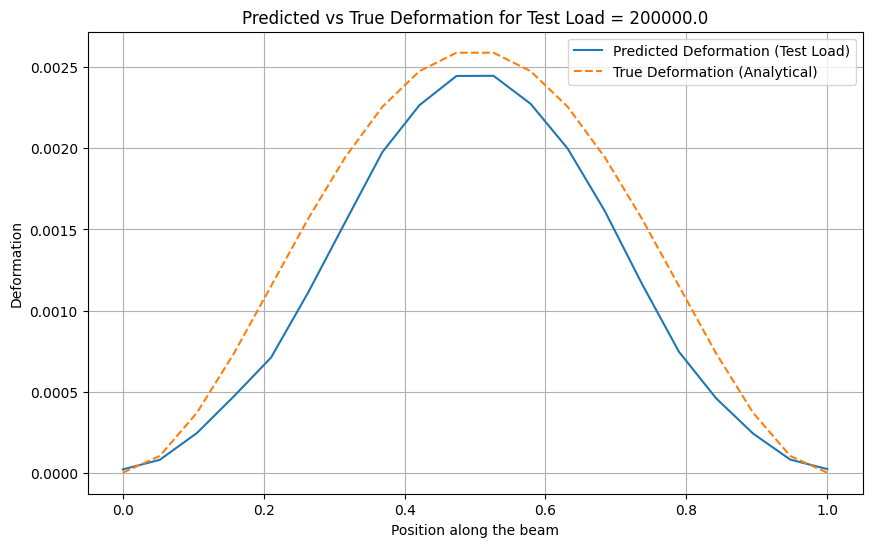

In [282]:

# -------------------
# Test load prediction and denormalization
# -------------------

# Define a test load (e.g., 7.0)
test_load = 2.0e5

# Create the test graph for the test load
test_graph = create_rod_graph(num_nodes, test_load, load_mean, load_std, position_mean, position_std)

# Predict the deformation using the trained model
with torch.no_grad():
    predicted_test_deformation_normalized = model(test_graph.x, test_graph.edge_index)

# Denormalize the predicted deformation for the test load
predicted_test_deformation = predicted_test_deformation_normalized * deformation_std + deformation_mean

# Compute the true deformation using the analytical solution for the test load
x_positions = torch.linspace(0, L, num_nodes)
true_test_deformation = beam_deflection(x_positions, L, test_load, E, I)

# Convert to numpy for plotting
x_positions_numpy = x_positions.numpy()
predicted_test_deformation_numpy = predicted_test_deformation.numpy()
true_test_deformation_numpy = true_test_deformation.numpy()

# Plot the comparison between predicted and true deformation for the test load
plt.figure(figsize=(10, 6))
plt.plot(x_positions_numpy, predicted_test_deformation_numpy, label='Predicted Deformation (Test Load)')
plt.plot(x_positions_numpy, true_test_deformation_numpy, label='True Deformation (Analytical)', linestyle='--')
plt.title(f'Predicted vs True Deformation for Test Load = {test_load}')
plt.xlabel('Position along the beam')
plt.ylabel('Deformation')
plt.legend()
plt.grid(True)
plt.show()


In [273]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the MLP model
class RodDeformationMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RodDeformationMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Training function for MLP
def train_mlp(model, data_list, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_list:
        optimizer.zero_grad()
        out = model(data.x)  # MLP takes input features (position and load)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_list)


MLP Epoch 10/200, Loss: 0.0097
MLP Epoch 20/200, Loss: 0.0021
MLP Epoch 30/200, Loss: 0.0009
MLP Epoch 40/200, Loss: 0.0017
MLP Epoch 50/200, Loss: 0.0012
MLP Epoch 60/200, Loss: 0.0009
MLP Epoch 70/200, Loss: 0.0009
MLP Epoch 80/200, Loss: 0.0008
MLP Epoch 90/200, Loss: 0.0012
MLP Epoch 100/200, Loss: 0.0011
MLP Epoch 110/200, Loss: 0.0012
MLP Epoch 120/200, Loss: 0.0010
MLP Epoch 130/200, Loss: 0.0013
MLP Epoch 140/200, Loss: 0.0011
MLP Epoch 150/200, Loss: 0.0011
MLP Epoch 160/200, Loss: 0.0013
MLP Epoch 170/200, Loss: 0.0005
MLP Epoch 180/200, Loss: 0.0011
MLP Epoch 190/200, Loss: 0.0010
MLP Epoch 200/200, Loss: 0.0010


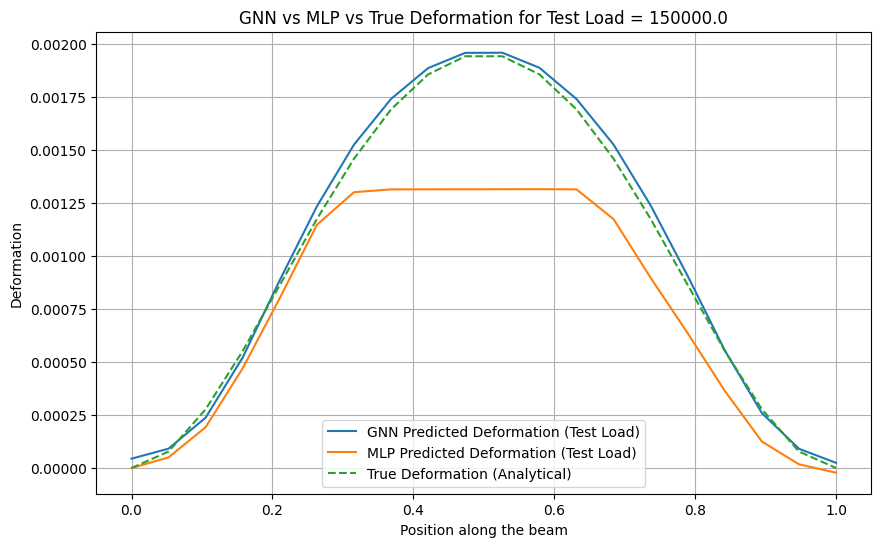

In [274]:
# Define the MLP
input_size = 2  # 2 input features: position and load
hidden_size = 64  # Same hidden size as the GNN
output_size = 1  # Output is the predicted deformation

mlp_model = RodDeformationMLP(input_size, hidden_size, output_size)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
mlp_criterion = nn.MSELoss()

# Training the MLP
mlp_num_epochs = 200
for epoch in range(mlp_num_epochs):
    mlp_loss = train_mlp(mlp_model, data_list, mlp_optimizer, mlp_criterion)
    if (epoch + 1) % 10 == 0:
        print(f'MLP Epoch {epoch+1}/{mlp_num_epochs}, Loss: {mlp_loss:.4f}')

# Evaluate MLP on a training example
with torch.no_grad():
    mlp_predicted_deformation_normalized = mlp_model(training_data.x)

# Denormalize the MLP predictions
mlp_predicted_deformation = mlp_predicted_deformation_normalized * deformation_std + deformation_mean

# Plot comparison between MLP and GNN predictions on training data
# plt.figure(figsize=(10, 6))
# plt.plot(training_data.x[:, 0].numpy(), predicted_deformation.numpy(), label='GNN Predicted Deformation (Training Data)')
# plt.plot(training_data.x[:, 0].numpy(), mlp_predicted_deformation.numpy(), label='MLP Predicted Deformation (Training Data)')
# plt.plot(training_data.x[:, 0].numpy(), (training_data.y * max_deformation).numpy(), label='True Deformation (Analytical)', linestyle='--')
# plt.title('GNN vs MLP vs True Deformation (Training Data)')
# plt.xlabel('Position along the beam')
# plt.ylabel('Deformation')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:

# -------------------
# Test load prediction for MLP
# -------------------

# Predict the deformation using the MLP for the test load
with torch.no_grad():
    mlp_predicted_test_deformation_normalized = mlp_model(test_graph.x)

# Denormalize the predicted deformation for the test load
mlp_predicted_test_deformation = mlp_predicted_test_deformation_normalized * deformation_std + deformation_mean

# Plot the comparison between GNN, MLP, and true deformation for the test load
plt.figure(figsize=(10, 6))
plt.plot(x_positions_numpy, predicted_test_deformation_numpy, label='GNN Predicted Deformation (Test Load)')
plt.plot(x_positions_numpy, mlp_predicted_test_deformation.numpy(), label='MLP Predicted Deformation (Test Load)')
plt.plot(x_positions_numpy, true_test_deformation_numpy, label='True Deformation (Analytical)', linestyle='--')
plt.title(f'GNN vs MLP vs True Deformation for Test Load = {test_load}')
plt.xlabel('Position along the beam')
plt.ylabel('Deformation')
plt.legend()
plt.grid(True)
plt.show()